In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/kaggle/input/nyc-property-sales/nyc-rolling-sales.csv')
df['SALE DATE'] = df['SALE DATE'].str[:7]
df.columns
cont_cols = ['YEAR BUILT', 'GROSS SQUARE FEET', 'LAND SQUARE FEET', 'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', ]
cat_cols = ['NEIGHBORHOOD', 'BUILDING CLASS CATEGORY', 'BUILDING CLASS AT TIME OF SALE', 'SALE DATE']
label_cols = ['SALE PRICE']


for cat in cat_cols:
    df[cat] = df[cat].astype('category')
    
buildingclass = df['BUILDING CLASS CATEGORY'].cat.codes.values
neighborhood = df['NEIGHBORHOOD'].cat.codes.values
buildingclassatsale = df['BUILDING CLASS AT TIME OF SALE'].cat.codes.values
saledate = df['SALE DATE'].cat.codes.values
cats = np.stack([buildingclass,neighborhood,buildingclassatsale, saledate], 1)
cats = torch.tensor(cats, dtype=torch.int64)
for cont in cont_cols:
    df[cont] = pd.to_numeric(df[cont], errors='coerce')
 

for cont in label_cols:
    df[cont] = pd.to_numeric(df[cont], errors='coerce')
    
df = df.sample(frac=1).reset_index(drop=True)

df.dropna(inplace=True)
print(len(df[cont_cols]))
i = 0



conts = np.stack([df[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
labels = np.stack([df[col].values for col in label_cols], 1)
labels = torch.tensor(labels, dtype=torch.float)


iSub = 0
for i in range(len(labels)-1):
 
    if (labels[i + iSub][0]) < 200000.0 or (labels[i + iSub][0]) > 5000000.0 :
        if len(labels) == i + 1 + iSub:
            labels= torch.cat([labels[0:i+iSub]])
            conts= torch.cat([conts[0:i+iSub]])
        else:
            labels= torch.cat([labels[0:i+iSub], labels[i+1+iSub:]])
            conts= torch.cat([conts[0:i+iSub], conts[i+1+iSub:]])
            cats= torch.cat([cats[0:i+iSub], cats[i+1+iSub:]])
            iSub -= 1
            
            
iSub = 0
for i in range(len(conts)-1):
 
    if (conts[i + iSub][1]) < 1:
        if len(conts) == i + 1 + iSub:
            labels= torch.cat([label[0:i+iSub]])
            conts= torch.cat([conts[0:i+iSub]])
        else:
            labels= torch.cat([labels[0:i+iSub], labels[i+1+iSub:]])
            conts= torch.cat([conts[0:i+iSub], conts[i+1+iSub:]])
            cats= torch.cat([cats[0:i+iSub], cats[i+1+iSub:]])
            iSub -= 1

48244


In [2]:
class BasicModel(nn.Module):
    def __init__(self, in_features=9, h1=20, h2=40, out_features=1):
        super().__init__()
        self.fc1 = nn.Linear(in_features,h1)    # input layer
        self.fc2 = nn.Linear(h1, h2)     
        self.fc3 = nn.Linear(h2, h1)     # hidden layer
        self.out = nn.Linear(h1, out_features)  # output layer
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x
model = BasicModel()
torch.manual_seed(69)
criterion = nn.L1Loss()
#criterion = nn.CrossEntropyLoss()
#Test and find a learning rate that makes your model successful. I recommend using multiples of 10 (moving a decimal point) until you get
#close, then multiples of 5 if necessary.
optimizer = torch.optim.Adam(model.parameters(), lr=.1)

In [3]:
batch_size = 2000
#If our batch size is 50, what should the test size be?
test_size = 800

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = labels[:batch_size-test_size]
y_test = labels[batch_size-test_size:batch_size]

x_train = torch.cat((cat_train, con_train), 1)
x_test = torch.cat((cat_test, con_test), 1)

In [4]:
epochs = 1000
losses = []

for i in range(epochs):
    y_pred = model.forward(x_train)
    loss = torch.sqrt(criterion(y_pred, y_train))
    losses.append(loss)
    
    if i %(epochs / 20 )== 0:
        print(f'epoch: {i:2}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

epoch:  0  loss: 894.54113770
epoch: 50  loss: 589.36413574
epoch: 100  loss: 566.14245605
epoch: 150  loss: 553.41723633
epoch: 200  loss: 557.08764648
epoch: 250  loss: 552.62005615
epoch: 300  loss: 552.75579834
epoch: 350  loss: 550.58850098
epoch: 400  loss: 550.19024658
epoch: 450  loss: 549.66839600
epoch: 500  loss: 548.80310059
epoch: 550  loss: 548.69726562
epoch: 600  loss: 547.61346436
epoch: 650  loss: 549.66827393
epoch: 700  loss: 547.98132324
epoch: 750  loss: 546.87640381
epoch: 800  loss: 546.23162842
epoch: 850  loss: 546.75512695
epoch: 900  loss: 547.52795410
epoch: 950  loss: 545.37176514


predicted 991,064.875 actual 818,587.0
predicted 528,303.4375 actual 417,000.0
predicted 748,086.8125 actual 1,200,000.0
predicted 760,781.0625 actual 600,000.0
predicted 1,763,511.375 actual 995,000.0
predicted 1,426,148.5 actual 478,400.0
predicted 2,513,535.5 actual 1,300,000.0
predicted 1,241,585.625 actual 1,600,000.0
predicted 544,326.6875 actual 470,000.0
predicted 6.415526866912842 actual 4,223,025.0
predicted 1,693,534.25 actual 260,000.0
predicted 1,426,920.875 actual 1,425,000.0
predicted 503,838.75 actual 450,000.0
predicted 404,565.40625 actual 360,000.0
predicted 696,796.3125 actual 460,000.0
predicted 506,788.25 actual 345,112.0
predicted 465,050.03125 actual 735,000.0
predicted 950,623.0625 actual 950,000.0
predicted 1,204,924.625 actual 400,000.0
predicted 972,210.6875 actual 730,000.0
 average off by 575,792.552602344


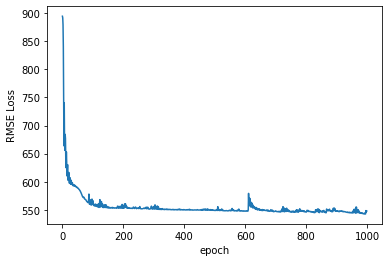

In [5]:
offset = 1000
batch_size = 25000
test_size =0
cat_train = cats[offset:(batch_size-test_size)+ offset]
cat_test = cats[offset + (batch_size-test_size):offset+batch_size]
con_train = conts[offset:(batch_size-test_size)+ offset]
con_test = conts[offset+ (batch_size-test_size):offset+batch_size]

y_train = labels[offset:offset+(batch_size-test_size)]
y_test = labels[offset+(batch_size-test_size):offset+batch_size]


x_train = torch.cat((cat_train, con_train), 1)
x_test = torch.cat((cat_test, con_test), 1)
difference = 0
for i in range(batch_size - test_size):
    difference += abs((y_train[i]).item() - (model.forward(x_train[i])).item() )
    if i %((batch_size - test_size) / 20 )== 0:
        print(f'predicted {(model.forward(x_train[i])).item():,} actual {(y_train[i]).item():,}')
        
        

#difference = 0;
#for i in range(20):
   # print(f'predicted { ((model.forward(conts[0 + i*20]))[0]):,} actual {(labels[i*20][0]):,}')
   # difference += abs((labels[i*50][0]) - ((model.forward(conts[0 + i*50]))[0]) )
    
print (f' average off by {difference /(batch_size - test_size):,}')
with torch.no_grad():
  plt.plot(range(epochs), losses)
  plt.ylabel('RMSE Loss')
  plt.xlabel('epoch');